<a target="_blank" href="https://colab.research.google.com/github/olsenlabmit/Polymer-Ensemble-Similarity/blob/main/notebook/Example2_First_order_Markov_Copolymer_Ensemble_Colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# @title Copyright & License (click to expand)

#MIT License

#Copyright (c) 2023 olsenlabmit

#Permission is hereby granted, free of charge, to any person obtaining a copy
#of this software and associated documentation files (the "Software"), to deal
#in the Software without restriction, including without limitation the rights
#to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
#copies of the Software, and to permit persons to whom the Software is
#furnished to do so, subject to the following conditions:

#The above copyright notice and this permission notice shall be included in all
#copies or substantial portions of the Software.

#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
#IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
#FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
#AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
#LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
#OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
#SOFTWARE.

# Download the necessary local functions, tables, and dataset

In [1]:
!gdown --folder https://drive.google.com/drive/folders/1DQ6e2Sgi4VlrA47KPYltN8zOJAvKt-jH?usp=sharing -O .

Retrieving folder list
Retrieving folder 1y8WkEeK5TmfETggrRyh5QFeyLOt1AMkU dataset
Retrieving folder 1N1CMgZsatgNQQWQm_r22G0q_vDHYAAPD Example1
Retrieving folder 1W2VPS3-ho_FQwF0y-R0nG7U-wxWd_lFz Ensemble_P
Processing file 14xH4Z1WczHGv8N8aw0RQy0pMUstgkC1X p1_graph.txt
Processing file 1iLvUezZgJSVmzFCzjnZY0J3NWWf5ab5i p2_graph.txt
Retrieving folder 1oUsv9K7PxWC75w5DZmnF_70sL9cG5z25 Ensemble_Q
Processing file 1xlpCSJHciMvPiWVMpvH31OA_4cRKGYm5 q1_graph.txt
Processing file 1vKMfC7XSuyLU8igAl6H6oMzRc1cKDN7j q2_graph.txt
Retrieving folder 15rNBmTtM59FuZNBWZ6dG5AAmE2djMkXj Example2
Retrieving folder 1leVkq4YVM-K-GWpK_veb6W3WitNnAnzh GED_JSON
Processing file 1sfHGRi-tV6wuIJtGaJGSBKWnuuofBMO0 CopolymerL10_GED_Dict_fp_all.json
Processing file 1dRWwoW0bf-DnpQc7JNgleSSaZ1MpSt8I CopolymerL10_GED_Dict_fp_tacticity.json
Processing file 1sIIV0xgGG2UgR_5IO6MV6J1zozSAox6m CopolymerL10_GED_Dict_onehot_all.json
Retrieving folder 1TOcO1tqF3OM_MTKXbmkulbODxRjg4xMK lambda00
Processing file 1gthxCCN8pA8Ox1NK

# Import the required library

In [24]:
import random
import numpy as np
import shutil
import sys
import os.path
import json
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

if not shutil.which("rdkit"):
    !pip install -q rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

if not shutil.which("grakel"):
    !pip install grakel

if not shutil.which("dgl"):
    !pip install dgl

if not shutil.which("umap"):
    !pip install umap-learn

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert shutil.which("pyomo")

from pyomo.environ import *

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert shutil.which("cbc") or os.path.isfile("cbc")

from utils.load_networkx import networkx_feat
from utils import macro_unsupervised as unsup
from utils import plot

print("Import Library Done!")

Import Library Done!


# Load the Ensembles of Example 2

Those polymer ensembles were generated with first-order Markov Model under different $\lambda$ values, \\
$\lambda = [1.0, 0.5, 0.0, -0.5, -1.0]$


In [3]:
# lambda = 1.0
Ensemble_lambda_P10 = np.load("./dataset/Example2/lambda10/unique_seqs_list.npy")

Ensemble_lambda_P10_weight = np.load("./dataset/Example2/lambda10/unique_seqs_index_list.npy")

# lambda = 0.5
Ensemble_lambda_P05 = np.load("./dataset/Example2/lambda05/unique_seqs_list.npy")

Ensemble_lambda_P05_weight = np.load("./dataset/Example2/lambda05/unique_seqs_index_list.npy")

# lambda = 0.0
Ensemble_lambda_00 = np.load("./dataset/Example2/lambda00/unique_seqs_list.npy")

Ensemble_lambda_00_weight = np.load("./dataset/Example2/lambda00/unique_seqs_index_list.npy")

# lambda = -0.5
Ensemble_lambda_N05 = np.load("./dataset/Example2/lambdaN05/unique_seqs_list.npy")

Ensemble_lambda_N05_weight = np.load("./dataset/Example2/lambdaN05/unique_seqs_index_list.npy")

# lambda = -1.0
Ensemble_lambda_N10 = np.load("./dataset/Example2/lambdaN10/unique_seqs_list.npy")

Ensemble_lambda_N10_weight = np.load("./dataset/Example2/lambdaN10/unique_seqs_index_list.npy")

# Load the stored GED results

In [7]:
onehot_ged_filename = "./dataset/Example2/GED_JSON/CopolymerL10_GED_Dict_onehot_all.json"
with open(onehot_ged_filename,'r') as json_file:
    onehot_GED_Dict = json.load(json_file)


fp_ged_filename = "./dataset/Example2/GED_JSON/CopolymerL10_GED_Dict_fp_all.json"
with open(fp_ged_filename,'r') as json_file:
    fp_GED_Dict = json.load(json_file)

In [10]:
def number_transformation(x):
    number_x = 0

    for i in range(0,10):
        number_x = number_x + pow(2,i)*x[i]

    return number_x

def distance_calculation(x,y,alpha=1,embedding_method = 'onehot'):

    number_x = number_transformation(x)

    number_y = number_transformation(y)

    key = 'GBID'+str(number_x) + ',' 'GBID'+str(number_y)

    if embedding_method == 'onehot':
        GED = onehot_GED_Dict[key]

    elif embedding_method == 'fp':

        GED = fp_GED_Dict[key]

    distance_score = 1-np.exp(-alpha*GED/10)

    return distance_score

# EMD function

In [16]:
def Calculate_EMD(ensembleP = None,
                  ensembleP_weight = None,
                  ensembleQ = None,
                  ensembleQ_weight = None,
                  alpha = 1,
                  embedding_method='onehot',
                  print_details = False
                         ):

    Demand = {}
    Supply = {}
    T = {}

    ensembleP_number = len(ensembleP_weight)

    ensembleP_weight_sum = sum(ensembleP_weight)


    for i in range(0, ensembleP_number):

            Demand["P" + str(i+1)] = ensembleP_weight[i]/ensembleP_weight_sum

    ensembleQ_number = len(ensembleQ_weight)

    ensembleQ_weight_sum = sum(ensembleQ_weight)


    for j in range(0, ensembleQ_number):

            Supply["Q" + str(j+1)]= ensembleQ_weight[j]/ensembleQ_weight_sum

    for i in range(0,ensembleP_number):

        for j in range(0, ensembleQ_number):


            T[("P"+str(i+1),"Q"+str(j+1))] = distance_calculation(
                                x = ensembleP[i],
                                y = ensembleQ[j],
                                alpha=alpha,
                                embedding_method = embedding_method)


    # Step 0: Create an instance of the model
    model = ConcreteModel()
    model.dual = Suffix(direction=Suffix.IMPORT)

    # Step 1: Define index sets
    CUS = list(Demand.keys())
    SRC = list(Supply.keys())

    # Step 2: Define the decision
    model.x = Var(CUS, SRC, domain = NonNegativeReals)

    # Step 3: Define Objective
    model.Cost = Objective(
    expr = sum([T[c,s]*model.x[c,s] for c in CUS for s in SRC]),
    sense = minimize)

    # Step 4: Constraints
    model.src = ConstraintList()
    for s in SRC:
        model.src.add(sum([model.x[c,s] for c in CUS]) <= Supply[s])

    model.dmd = ConstraintList()
    for c in CUS:
        model.dmd.add(sum([model.x[c,s] for s in SRC]) == Demand[c])

    results = SolverFactory('cbc').solve(model)

    if 'ok' == str(results.Solver.status):
        if print_details == True:
            for s in SRC:
                for c in CUS:
                    if model.x[c,s]() > 0:
                        print("Ship from ", s," to ", c, ":",
                              model.x[c,s](),"*" ,T[c,s])
        return model.Cost()

    else:
        print("No Valid Solution Found")
        return False

# The calculation of EMD(P,Q) and S(P,Q)

In [33]:
EMD_onehot = Calculate_EMD(ensembleP = Ensemble_lambda_P05,
                         ensembleP_weight = Ensemble_lambda_P05_weight,
                         ensembleQ = Ensemble_lambda_00,
                         ensembleQ_weight = Ensemble_lambda_00_weight,
                         alpha = 1,
                         embedding_method = 'onehot',
                         print_details = False)

print("EMD_onehot(lambda=0.5,lambda=0.0) = ", EMD_onehot)
print("S_onehot(lambda=0.5,lambda=0.0) = ", 1-EMD_onehot)

EMD_onehot(lambda=0.5,lambda=0.0) =  0.11281326061552666
S_onehot(lambda=0.5,lambda=0.0) =  0.8871867393844733


In [34]:
EMD_fp = Calculate_EMD(ensembleP = Ensemble_lambda_P05,
                         ensembleP_weight = Ensemble_lambda_P05_weight,
                         ensembleQ = Ensemble_lambda_00,
                         ensembleQ_weight = Ensemble_lambda_00_weight,
                         alpha = 1,
                         embedding_method = 'fp',
                         print_details = False)

print("EMD_fp(lambda=0.5,lambda=0.0) = ", EMD_fp)
print("S_fp(lambda=0.5,lambda=0.0) = ", 1-EMD_fp)

EMD_fp(lambda=0.5,lambda=0.0) =  0.06722963970699482
S_fp(lambda=0.5,lambda=0.0) =  0.9327703602930052


In [28]:
Example2_Ensembles = [
    Ensemble_lambda_P10,
    Ensemble_lambda_P05,
    Ensemble_lambda_00,
    Ensemble_lambda_N05,
    Ensemble_lambda_N10,
]

Example2_Ensembles_weights = [
    Ensemble_lambda_P10_weight,
    Ensemble_lambda_P05_weight,
    Ensemble_lambda_00_weight,
    Ensemble_lambda_N05_weight,
    Ensemble_lambda_N10_weight,
]

Example2_Ensembles_names = [
    "lambda=1.0",
    "lambda=0.5",
    "lambda=0.0",
    "lambda=-0.5",
    "lambda=-1.0",
]

# Onehot encoding results of pairwise similarity

In [29]:
S_onehot_matrix = np.ones([5,5])

for i in range(0,4):

    for j in range(i+1,5):

        EMD_onehot_ij = Calculate_EMD(ensembleP = Example2_Ensembles[i],
                         ensembleP_weight = Example2_Ensembles_weights[i],
                         ensembleQ = Example2_Ensembles[j],
                         ensembleQ_weight = Example2_Ensembles_weights[j],
                         alpha = 1,
                         embedding_method = 'onehot',
                         print_details = False)

        S_onehot_ij = 1-EMD_onehot_ij

        print(f"EMD({Example2_Ensembles_names[i]},{Example2_Ensembles_names[j]})=",
              EMD_onehot_ij)
        print(f"S({Example2_Ensembles_names[i]},{Example2_Ensembles_names[j]})=",
              S_onehot_ij)
        print('\n')

        S_onehot_matrix[i,j] = S_onehot_ij
        S_onehot_matrix[j,i] = S_onehot_ij

EMD(lambda=1.0,lambda=0.5)= 0.24433210684564508
S(lambda=1.0,lambda=0.5)= 0.7556678931543549


EMD(lambda=1.0,lambda=0.0)= 0.31058526124836683
S(lambda=1.0,lambda=0.0)= 0.6894147387516332


EMD(lambda=1.0,lambda=-0.5)= 0.3481956973809434
S(lambda=1.0,lambda=-0.5)= 0.6518043026190565


EMD(lambda=1.0,lambda=-1.0)= 0.3934693402873666
S(lambda=1.0,lambda=-1.0)= 0.6065306597126334


EMD(lambda=0.5,lambda=0.0)= 0.11281326061552666
S(lambda=0.5,lambda=0.0)= 0.8871867393844733


EMD(lambda=0.5,lambda=-0.5)= 0.21135528288686267
S(lambda=0.5,lambda=-0.5)= 0.7886447171131373


EMD(lambda=0.5,lambda=-1.0)= 0.3480720217987231
S(lambda=0.5,lambda=-1.0)= 0.6519279782012769


EMD(lambda=0.0,lambda=-0.5)= 0.11276939312445443
S(lambda=0.0,lambda=-0.5)= 0.8872306068755456


EMD(lambda=0.0,lambda=-1.0)= 0.30739176596202994
S(lambda=0.0,lambda=-1.0)= 0.69260823403797


EMD(lambda=-0.5,lambda=-1.0)= 0.22872080961501956
S(lambda=-0.5,lambda=-1.0)= 0.7712791903849805




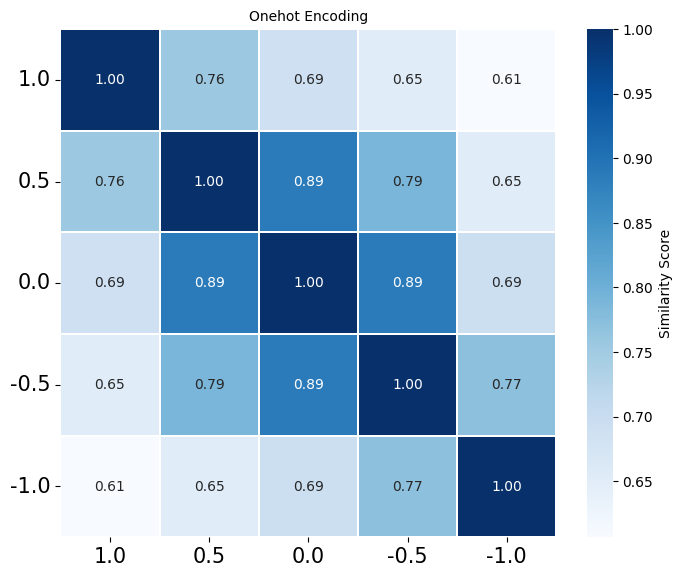

In [30]:
fig, ax = plt.subplots(figsize=(8,6.6),sharey=True )

x_labels = ["1.0", "0.5", "0.0", "-0.5", "-1.0"]
y_labels = ["1.0", "0.5", "0.0", "-0.5", "-1.0"]

sns.heatmap(S_onehot_matrix, linewidth = 0.3, annot = True, fmt = ".2f" , cmap = "Blues",
            cbar_kws = {'label': 'Similarity Score'})
ax.set_title(r"Onehot Encoding", fontsize=10)
ax.set_xticklabels(x_labels, rotation = 0, fontsize = 15,
                   horizontalalignment = 'center')
ax.set_yticklabels(y_labels, rotation = 360, fontsize = 15,
                   horizontalalignment = 'right')
plt.show()

 # Fingerprint(FP) encoding results of pairwise similarity

In [31]:
S_fp_matrix = np.ones([5,5])

for i in range(0,4):

    for j in range(i+1,5):

        EMD_fp_ij = Calculate_EMD(ensembleP = Example2_Ensembles[i],
                         ensembleP_weight = Example2_Ensembles_weights[i],
                         ensembleQ = Example2_Ensembles[j],
                         ensembleQ_weight = Example2_Ensembles_weights[j],
                         alpha = 1,
                         embedding_method = 'fp',
                         print_details = False)

        S_fp_ij = 1-EMD_fp_ij

        print(f"EMD({Example2_Ensembles_names[i]},{Example2_Ensembles_names[j]})=",
              EMD_fp_ij)
        print(f"S({Example2_Ensembles_names[i]},{Example2_Ensembles_names[j]})=",
              S_fp_ij)
        print('\n')

        S_fp_matrix[i,j] = S_fp_ij
        S_fp_matrix[j,i] = S_fp_ij

EMD(lambda=1.0,lambda=0.5)= 0.148093627790761
S(lambda=1.0,lambda=0.5)= 0.851906372209239


EMD(lambda=1.0,lambda=0.0)= 0.18978505520897573
S(lambda=1.0,lambda=0.0)= 0.8102149447910243


EMD(lambda=1.0,lambda=-0.5)= 0.21442065550946515
S(lambda=1.0,lambda=-0.5)= 0.7855793444905348


EMD(lambda=1.0,lambda=-1.0)= 0.24516039801099265
S(lambda=1.0,lambda=-1.0)= 0.7548396019890073


EMD(lambda=0.5,lambda=0.0)= 0.06722963970699482
S(lambda=0.5,lambda=0.0)= 0.9327703602930052


EMD(lambda=0.5,lambda=-0.5)= 0.12795490582720875
S(lambda=0.5,lambda=-0.5)= 0.8720450941727913


EMD(lambda=0.5,lambda=-1.0)= 0.21439668779680568
S(lambda=0.5,lambda=-1.0)= 0.7856033122031943


EMD(lambda=0.0,lambda=-0.5)= 0.06720167898742233
S(lambda=0.0,lambda=-0.5)= 0.9327983210125776


EMD(lambda=0.0,lambda=-1.0)= 0.1893418123350811
S(lambda=0.0,lambda=-1.0)= 0.8106581876649189


EMD(lambda=-0.5,lambda=-1.0)= 0.14593134618678225
S(lambda=-0.5,lambda=-1.0)= 0.8540686538132177




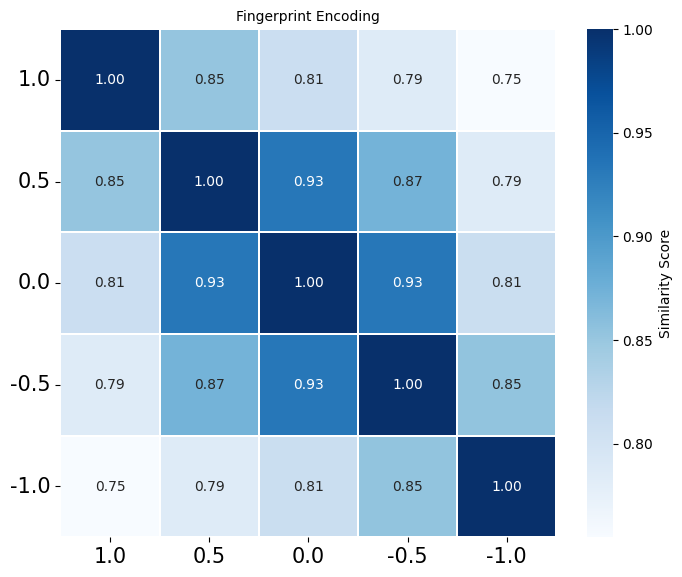

In [32]:
fig, ax = plt.subplots(figsize=(8,6.6),sharey=True )

x_labels = ["1.0", "0.5", "0.0", "-0.5", "-1.0"]
y_labels = ["1.0", "0.5", "0.0", "-0.5", "-1.0"]

sns.heatmap(S_fp_matrix, linewidth = 0.3, annot = True, fmt = ".2f" , cmap = "Blues",
            cbar_kws = {'label': 'Similarity Score'})
ax.set_title(r"Fingerprint Encoding", fontsize=10)
ax.set_xticklabels(x_labels, rotation = 0, fontsize = 15,
                   horizontalalignment = 'center')
ax.set_yticklabels(y_labels, rotation = 360, fontsize = 15,
                   horizontalalignment = 'right')
plt.show()